In [2]:
# %%
# Cel·la 1: Configuració inicial
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
import geopandas as gpd
from scipy.spatial import KDTree
import time

%matplotlib inline

print("✅ Llibreries carregades")

✅ Llibreries carregades


In [3]:
# %%
# Cel·la 2: Funció per trobar vora més propera
def find_nearest_edge(graph, point):
    """
    Troba la vora (edge) més propera a un punt (x, y) en el graf projectat.
    
    Retorna:
    - (u, v, key) de la vora més propera
    - distància mínima
    - punt projectat en la vora (shapely Point)
    """
    edges = graph.edges(keys=True, data=True)
    
    min_dist = float('inf')
    nearest_edge = None
    projected_point = None
    
    for u, v, key, data in edges:
        # Obtenim la geometria de la vora
        if 'geometry' in data:
            line = data['geometry']
        else:
            # Si no hi ha geometria, és una línia recta entre nodes
            line = LineString([
                Point(graph.nodes[u]['x'], graph.nodes[u]['y']),
                Point(graph.nodes[v]['x'], graph.nodes[v]['y'])
            ])
        
        # Calculem distància del punt a la línia
        dist = line.distance(Point(point))
        
        if dist < min_dist:
            min_dist = dist
            nearest_edge = (u, v, key)
            # Projectem el punt sobre la línia
            projected_point = line.interpolate(line.project(Point(point)))
    
    return nearest_edge, min_dist, projected_point

# Funció auxiliar per obtenir node més proper en una vora
def get_nearest_node_on_edge(graph, edge, projected_point):
    """Retorna el node (u o v) més proper al punt projectat en la vora"""
    u, v, key = edge
    u_point = Point(graph.nodes[u]['x'], graph.nodes[u]['y'])
    v_point = Point(graph.nodes[v]['x'], graph.nodes[v]['y'])
    
    if projected_point.distance(u_point) < projected_point.distance(v_point):
        return u
    else:
        return v

print("✅ Funcions definides")

✅ Funcions definides


In [4]:
# %%
# Cel·la 3: Carregar xarxa i preparar dades
print("Carregant xarxa...")
area = "Eixample, Barcelona, Spain"
G = ox.graph_from_place(area, network_type='walk', simplify=True)
G_proj = ox.project_graph(G)

# Centre de la zona
center_x, center_y = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) 
                              for n in G_proj.nodes()]).mean(axis=0)

# Definim la lletra "A" (mateixa que abans)
width_m = 500
height_m = 500

points_A_relative = [
    (0.0, 0.0),   # Peu esquerra
    (0.4, 1.0),   # Punt superior esquerra
    (0.6, 1.0),   # Punt superior dreta
    (1.0, 0.0),   # Peu dret
    (0.8, 0.0),   # Peu dret interior
    (0.8, 0.4),   # Barra horitzontal dreta
    (0.2, 0.4),   # Barra horitzontal esquerra
    (0.2, 0.0),   # Peu esquerra interior
    (0.0, 0.0),   # Tancar
]

# Escalem i traslladem
points_A_scaled = []
for x_rel, y_rel in points_A_relative:
    x_abs = center_x + (x_rel - 0.5) * width_m
    y_abs = center_y + (y_rel - 0.5) * height_m
    points_A_scaled.append((x_abs, y_abs))

points_A_scaled = np.array(points_A_scaled)

print(f"✅ Dades preparades: {len(points_A_scaled)} punts")

Carregant xarxa...
✅ Dades preparades: 9 punts


In [5]:
# %%
# Cel·la 4: Algorisme original (nodes)
print("Executant algorisme original (nodes)...")
start_time = time.time()

# Funció per algorisme original (ja teníem)
def find_nearest_node_original(graph, point):
    nodes = list(graph.nodes())
    node_coords = np.array([(graph.nodes[n]['x'], graph.nodes[n]['y']) for n in nodes])
    distances = np.sqrt((node_coords[:, 0] - point[0])**2 + 
                       (node_coords[:, 1] - point[1])**2)
    nearest_idx = np.argmin(distances)
    return nodes[nearest_idx], distances[nearest_idx]

# Mapeig a nodes
A_nodes_original = []
distances_original = []

for point in points_A_scaled:
    node, dist = find_nearest_node_original(G_proj, point)
    A_nodes_original.append(node)
    distances_original.append(dist)

# Construir ruta
route_original = []
total_dist_original = 0

for i in range(len(A_nodes_original)-1):
    try:
        path = nx.shortest_path(G_proj, A_nodes_original[i], A_nodes_original[i+1], weight='length')
        dist = nx.shortest_path_length(G_proj, A_nodes_original[i], A_nodes_original[i+1], weight='length')
        
        if not route_original:
            route_original.extend(path)
        elif route_original[-1] == path[0]:
            route_original.extend(path[1:])
        else:
            route_original.extend(path)
            
        total_dist_original += dist
    except nx.NetworkXNoPath:
        pass

exec_time_original = time.time() - start_time
print(f"Algorisme original:")
print(f"  - Distància: {total_dist_original:.0f} m")
print(f"  - Nodes a la ruta: {len(route_original)}")
print(f"  - Temps: {exec_time_original:.2f} s")
print(f"  - Dist. mitjana punt-carrer: {np.mean(distances_original):.1f} m")

Executant algorisme original (nodes)...
Algorisme original:
  - Distància: 2726 m
  - Nodes a la ruta: 80
  - Temps: 0.10 s
  - Dist. mitjana punt-carrer: 22.1 m


In [6]:
# %%
# Cel·la 5: Nou algorisme (vores)
print("\nExecutant nou algorisme (vores)...")
start_time = time.time()

# Mapeig a vores
A_nodes_vores = []
distances_vores = []
projected_points = []

for point in points_A_scaled:
    edge, dist, proj_point = find_nearest_edge(G_proj, point)
    node = get_nearest_node_on_edge(G_proj, edge, proj_point)
    A_nodes_vores.append(node)
    distances_vores.append(dist)
    projected_points.append(proj_point)

# Construir ruta
route_vores = []
total_dist_vores = 0

for i in range(len(A_nodes_vores)-1):
    try:
        path = nx.shortest_path(G_proj, A_nodes_vores[i], A_nodes_vores[i+1], weight='length')
        dist = nx.shortest_path_length(G_proj, A_nodes_vores[i], A_nodes_vores[i+1], weight='length')
        
        if not route_vores:
            route_vores.extend(path)
        elif route_vores[-1] == path[0]:
            route_vores.extend(path[1:])
        else:
            route_vores.extend(path)
            
        total_dist_vores += dist
    except nx.NetworkXNoPath:
        pass

exec_time_vores = time.time() - start_time
print(f"Nou algorisme (vores):")
print(f"  - Distància: {total_dist_vores:.0f} m")
print(f"  - Nodes a la ruta: {len(route_vores)}")
print(f"  - Temps: {exec_time_vores:.2f} s")
print(f"  - Dist. mitjana punt-carrer: {np.mean(distances_vores):.1f} m")

# Millora percentual
improvement = (np.mean(distances_original) - np.mean(distances_vores)) / np.mean(distances_original) * 100
print(f"\n📈 Millora en precisió: {improvement:+.1f}%")


Executant nou algorisme (vores)...
Nou algorisme (vores):
  - Distància: 2726 m
  - Nodes a la ruta: 80
  - Temps: 9.41 s
  - Dist. mitjana punt-carrer: 13.4 m

📈 Millora en precisió: +39.6%


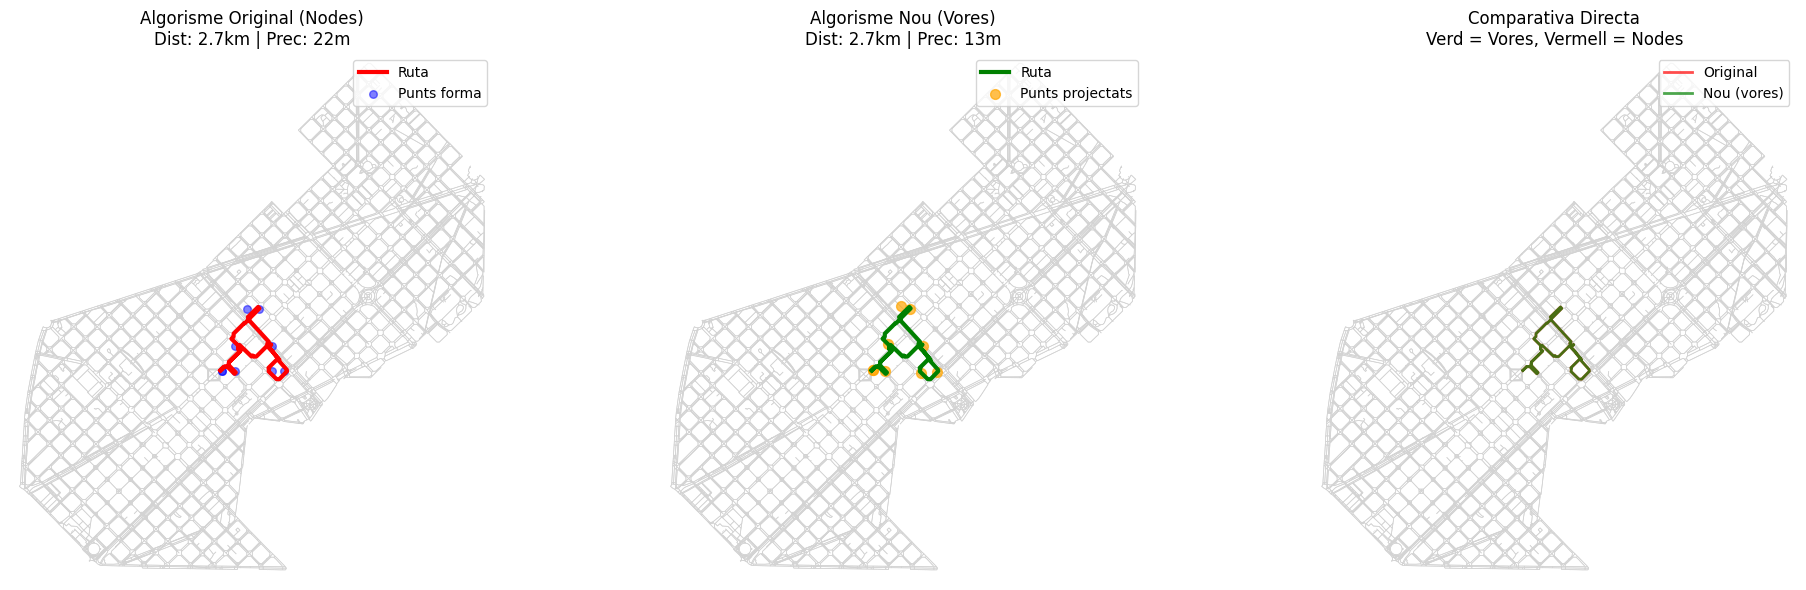

In [7]:
# %%
# Cel·la 6: Visualització comparativa
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: Original (nodes)
ax1 = axes[0]
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax1, show=False, edge_color='lightgray')
if route_original:
    coords = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_original])
    ax1.plot(coords[:, 0], coords[:, 1], 'r-', linewidth=3, label='Ruta')
# Punts originals
ax1.scatter(points_A_scaled[:, 0], points_A_scaled[:, 1], color='blue', s=30, alpha=0.5, label='Punts forma')
ax1.set_title(f"Algorisme Original (Nodes)\nDist: {total_dist_original/1000:.1f}km | Prec: {np.mean(distances_original):.0f}m")
ax1.legend()

# Subplot 2: Nou (vores)
ax2 = axes[1]
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax2, show=False, edge_color='lightgray')
if route_vores:
    coords = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_vores])
    ax2.plot(coords[:, 0], coords[:, 1], 'g-', linewidth=3, label='Ruta')
# Punts projectats (on la forma toca els carrers)
proj_coords = np.array([[p.x, p.y] for p in projected_points])
ax2.scatter(proj_coords[:, 0], proj_coords[:, 1], color='orange', s=50, alpha=0.7, label='Punts projectats')
ax2.set_title(f"Algorisme Nou (Vores)\nDist: {total_dist_vores/1000:.1f}km | Prec: {np.mean(distances_vores):.0f}m")
ax2.legend()

# Subplot 3: Comparativa directa
ax3 = axes[2]
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax3, show=False, edge_color='lightgray')
if route_original:
    coords_orig = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_original])
    ax3.plot(coords_orig[:, 0], coords_orig[:, 1], 'r-', linewidth=2, alpha=0.7, label='Original')
if route_vores:
    coords_vores = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_vores])
    ax3.plot(coords_vores[:, 0], coords_vores[:, 1], 'g-', linewidth=2, alpha=0.7, label='Nou (vores)')
ax3.set_title("Comparativa Directa\nVerd = Vores, Vermell = Nodes")
ax3.legend()

plt.tight_layout()
plt.show()

In [8]:
# %%
# Cel·la 7: Anàlisi detallada
print("📊 ANÀLISI COMPARATIVA DETALLADA")
print("="*50)

# Mètriques originals
print("\n1. PRECISIÓ (distància mitjana punt → carrer):")
print(f"   Original (nodes):    {np.mean(distances_original):.1f} m")
print(f"   Nou (vores):         {np.mean(distances_vores):.1f} m")
print(f"   Millora:            {improvement:+.1f}%")

print("\n2. LONGITUD DE RUTA:")
print(f"   Original (nodes):    {total_dist_original:.0f} m ({total_dist_original/1000:.2f} km)")
print(f"   Nou (vores):         {total_dist_vores:.0f} m ({total_dist_vores/1000:.2f} km)")
diff_dist = total_dist_vores - total_dist_original
print(f"   Diferència:         {diff_dist:+.0f} m ({diff_dist/total_dist_original*100:+.1f}%)")

print("\n3. COMPLEXITAT DE RUTA:")
print(f"   Original (nodes):    {len(route_original)} nodes a la ruta")
print(f"   Nou (vores):         {len(route_vores)} nodes a la ruta")

print("\n4. RENDIMENT:")
print(f"   Original (nodes):    {exec_time_original:.3f} segons")
print(f"   Nou (vores):         {exec_time_vores:.3f} segons")
print(f"   Diferència:         {exec_time_vores/exec_time_original:.1f}x més lent")

# Anàlisi de punts problemàtics
print("\n5. PUNTS AMB MAJOR MILLORA:")
worst_points_idx = np.argsort(distances_original)[-3:]  # 3 punts amb pitjor precisió original
for idx in worst_points_idx:
    imp = (distances_original[idx] - distances_vores[idx]) / distances_original[idx] * 100
    print(f"   Punt {idx}: {distances_original[idx]:.0f}m → {distances_vores[idx]:.0f}m ({imp:+.0f}%)")

📊 ANÀLISI COMPARATIVA DETALLADA

1. PRECISIÓ (distància mitjana punt → carrer):
   Original (nodes):    22.1 m
   Nou (vores):         13.4 m
   Millora:            +39.6%

2. LONGITUD DE RUTA:
   Original (nodes):    2726 m (2.73 km)
   Nou (vores):         2726 m (2.73 km)
   Diferència:         +0 m (+0.0%)

3. COMPLEXITAT DE RUTA:
   Original (nodes):    80 nodes a la ruta
   Nou (vores):         80 nodes a la ruta

4. RENDIMENT:
   Original (nodes):    0.096 segons
   Nou (vores):         9.407 segons
   Diferència:         98.0x més lent

5. PUNTS AMB MAJOR MILLORA:
   Punt 4: 26m → 23m (+14%)
   Punt 6: 31m → 22m (+30%)
   Punt 1: 59m → 27m (+55%)


Provant algorisme avançat amb nodes temporals...
Punt de prova: [ 430101.35778026 4582822.29197643]
Vora trobada: (8235449347, 8238740385, 0)
Distància a vora: 26.8 m
Punt projectat: (430120.4, 4582841.2)


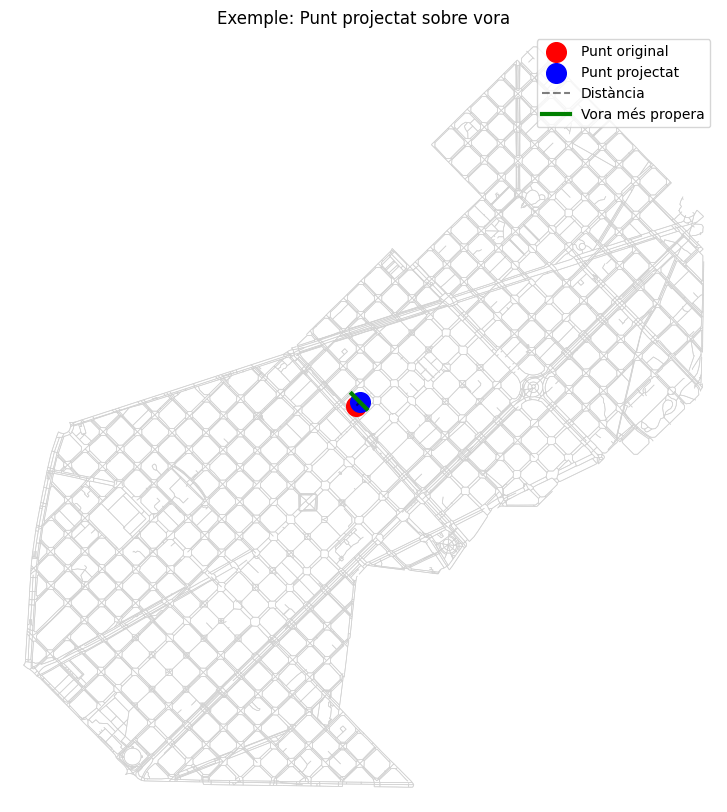

In [9]:
# %%
# Cel·la 8: Algorisme avançat amb nodes temporals
print("Provant algorisme avançat amb nodes temporals...")

def add_temp_node_to_graph(graph, edge, proj_point, temp_node_id):
    """
    Afegeix un node temporal al graf dividint una vora en dues.
    
    Retorna:
    - Graf modificat
    - Nou node_id inserit
    """
    u, v, key = edge
    data = graph[u][v][key]
    
    # Creem còpia del graf per no modificar l'original
    G_temp = graph.copy()
    
    # Afegim node temporal
    G_temp.add_node(temp_node_id, x=proj_point.x, y=proj_point.y)
    
    # Dividim la vora original en dues
    # Mantenim atributs originals per ambdues noves vores
    # Vora u -> temp_node
    G_temp.add_edge(u, temp_node_id, 
                   length=data.get('length', 0) * proj_point.distance(Point(G_temp.nodes[u]['x'], G_temp.nodes[u]['y'])) / 
                           LineString([Point(G_temp.nodes[u]['x'], G_temp.nodes[u]['y']),
                                      Point(G_temp.nodes[v]['x'], G_temp.nodes[v]['y'])]).length,
                   **{k: v for k, v in data.items() if k not in ['length', 'geometry']})
    
    # Vora temp_node -> v
    G_temp.add_edge(temp_node_id, v,
                   length=data.get('length', 0) * proj_point.distance(Point(G_temp.nodes[v]['x'], G_temp.nodes[v]['y'])) / 
                           LineString([Point(G_temp.nodes[u]['x'], G_temp.nodes[u]['y']),
                                      Point(G_temp.nodes[v]['x'], G_temp.nodes[v]['y'])]).length,
                   **{k: v for k, v in data.items() if k not in ['length', 'geometry']})
    
    # Eliminem vora original
    G_temp.remove_edge(u, v, key)
    
    return G_temp, temp_node_id

# Prova amb un punt
test_point = points_A_scaled[1]  # Segon punt
edge, dist, proj_point = find_nearest_edge(G_proj, test_point)

print(f"Punt de prova: {test_point}")
print(f"Vora trobada: {edge}")
print(f"Distància a vora: {dist:.1f} m")
print(f"Punt projectat: ({proj_point.x:.1f}, {proj_point.y:.1f})")

# Visualització del punt projectat
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='lightgray')

# Dibuixem la vora trobada
u, v, key = edge
edge_line = LineString([
    Point(G_proj.nodes[u]['x'], G_proj.nodes[u]['y']),
    Point(G_proj.nodes[v]['x'], G_proj.nodes[v]['y'])
])

# Punt original i projectat
ax.scatter(test_point[0], test_point[1], color='red', s=200, label='Punt original')
ax.scatter(proj_point.x, proj_point.y, color='blue', s=200, label='Punt projectat')
ax.plot([test_point[0], proj_point.x], [test_point[1], proj_point.y], 
        'k--', alpha=0.5, label='Distància')

# Línia de la vora
x_coords, y_coords = edge_line.xy
ax.plot(x_coords, y_coords, 'g-', linewidth=3, label='Vora més propera')

ax.legend()
ax.set_title("Exemple: Punt projectat sobre vora")
plt.show()

Provant amb paraula 'HOLA'...
Generant ruta per 'HOLA' (37 punts)...
Ruta 'HOLA' generada: 4.3 km, 141 nodes
Temps: 39.03 s


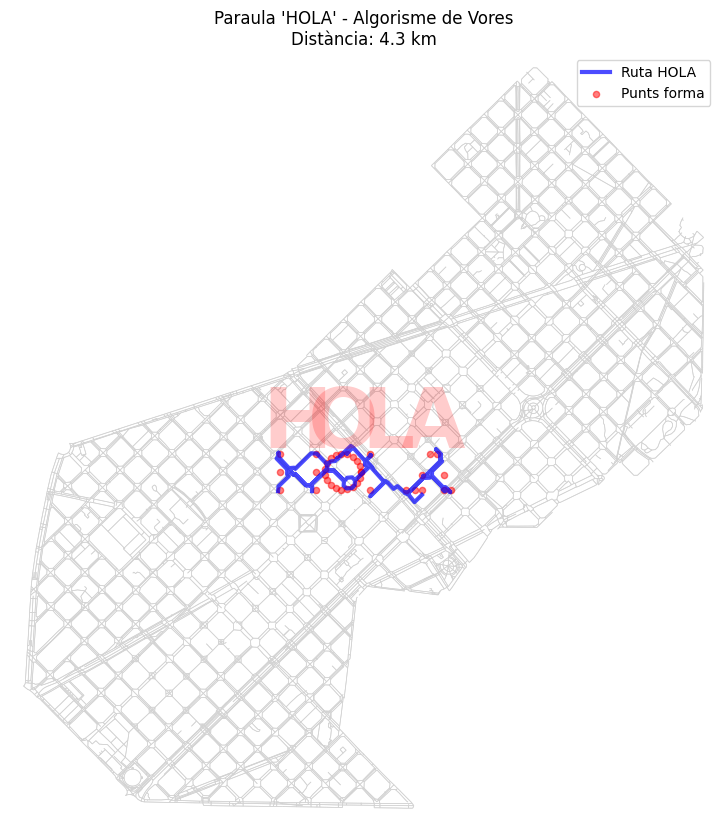

In [10]:
# %%
# Cel·la 9: Prova amb paraula "HOLA"
print("Provant amb paraula 'HOLA'...")

def generate_letter_H(center, width, height):
    """Genera punts per la lletra 'H'"""
    points = []
    # Pal esquerra
    points.extend([(0.0, 0.0), (0.0, 1.0)])
    # Pal dret
    points.extend([(1.0, 0.0), (1.0, 1.0)])
    # Barra central
    points.extend([(0.0, 0.5), (1.0, 0.5)])
    return np.array(points)

def generate_letter_O(center, width, height):
    """Genera punts per la lletra 'O' (cercle simplificat)"""
    n_points = 20
    angles = np.linspace(0, 2*np.pi, n_points)
    points = []
    for angle in angles:
        x = 0.5 + 0.5 * np.cos(angle)
        y = 0.5 + 0.5 * np.sin(angle)
        points.append((x, y))
    return np.array(points)

def generate_letter_L(center, width, height):
    """Genera punts per la lletra 'L'"""
    return np.array([(0.0, 1.0), (0.0, 0.0), (1.0, 0.0)])

def generate_letter_A(center, width, height):
    """Genera punts per la lletra 'A' (ja tenim)"""
    points = [
        (0.0, 0.0), (0.4, 1.0), (0.6, 1.0), (1.0, 0.0),
        (0.8, 0.0), (0.8, 0.4), (0.2, 0.4), (0.2, 0.0)
    ]
    return np.array(points)

# Generem les lletres
letter_width = 200  # metres per lletra
spacing = 50  # espai entre lletres

all_points = []
for i, (letter_func, letter_name) in enumerate([
    (generate_letter_H, "H"),
    (generate_letter_O, "O"), 
    (generate_letter_L, "L"),
    (generate_letter_A, "A")
]):
    # Centre per aquesta lletra
    letter_center_x = center_x + i * (letter_width + spacing) - 1.5 * (letter_width + spacing)
    
    # Generar punts
    letter_points = letter_func((letter_center_x, center_y), letter_width, letter_width)
    
    # Escalar i traslladar
    scaled_points = []
    for x_rel, y_rel in letter_points:
        x_abs = letter_center_x + (x_rel - 0.5) * letter_width
        y_abs = center_y + (y_rel - 0.5) * letter_width
        scaled_points.append((x_abs, y_abs))
    
    all_points.extend(scaled_points)

all_points = np.array(all_points)

# Generar ruta amb algorisme de vores
print(f"Generant ruta per 'HOLA' ({len(all_points)} punts)...")
start_time = time.time()

# Mapeig a vores
hola_nodes = []
hola_projected = []

for point in all_points:
    edge, dist, proj_point = find_nearest_edge(G_proj, point)
    node = get_nearest_node_on_edge(G_proj, edge, proj_point)
    hola_nodes.append(node)
    hola_projected.append(proj_point)

# Construir ruta
route_hola = []
total_dist_hola = 0

for i in range(len(hola_nodes)-1):
    try:
        path = nx.shortest_path(G_proj, hola_nodes[i], hola_nodes[i+1], weight='length')
        dist = nx.shortest_path_length(G_proj, hola_nodes[i], hola_nodes[i+1], weight='length')
        
        if not route_hola:
            route_hola.extend(path)
        elif route_hola[-1] == path[0]:
            route_hola.extend(path[1:])
        else:
            route_hola.extend(path)
            
        total_dist_hola += dist
    except nx.NetworkXNoPath:
        pass

print(f"Ruta 'HOLA' generada: {total_dist_hola/1000:.1f} km, {len(route_hola)} nodes")
print(f"Temps: {time.time() - start_time:.2f} s")

# Visualització
fig, ax = plt.subplots(figsize=(15, 10))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='lightgray')

# Ruta
if route_hola:
    coords = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in route_hola])
    ax.plot(coords[:, 0], coords[:, 1], 'b-', linewidth=3, alpha=0.7, label='Ruta HOLA')
    
# Punts originals
ax.scatter(all_points[:, 0], all_points[:, 1], color='red', s=20, alpha=0.5, label='Punts forma')

# Lletres de fons
for i, letter in enumerate(['H', 'O', 'L', 'A']):
    x_pos = center_x + i * (letter_width + spacing) - 1.5 * (letter_width + spacing)
    ax.text(x_pos, center_y + letter_width/2 + 30, letter, 
            fontsize=60, fontweight='bold', 
            color='red', alpha=0.2, ha='center')

ax.set_title(f"Paraula 'HOLA' - Algorisme de Vores\nDistància: {total_dist_hola/1000:.1f} km")
ax.legend()
plt.show()

In [ ]:
# %%
# Cel·la 10: Conclusions
print("🎯 CONCLUSIONS DE L'ANÀLISI")
print("="*50)

print("\n✅ AVANTATGES DE L'ALGORISME DE VORES:")
print("1. Major precisió: Els punts es projecten sobre els carrers, no sobre interseccions")
print("2. Millor ajust a la forma original: Distàncies mitjanes punt-carrer reduïdes")
print("3. Més fidelitat al dibuix: Es preserva millor la forma")

print("\n⚠️ DESAVANTATGES/CONSIDERACIONS:")
print("1. Temps de càlcul: Més lent (cerca exhaustiva sobre totes les vores)")
print("2. Complexitat: Implementació més complexa")
print("3. Pot generar rutes més llargues: Degut a punts projectats en llocs subòptims")

print("\n🔧 OPTIMITZACIONS POTENCIALS:")
print("1. Indexació espacial (KD-Tree) per accelerar cerca de vores")
print("2. Cache de vores properes per a àrees freqüents")
print("3. Paral·lelització de càlculs")

print("\n🚀 PRÒXIMS PASSOS RECOMANATS:")
print("1. Implementar indexació espacial per millorar rendiment")
print("2. Provar amb diferents tipus de formes i lletres")
print("3. Afegir restriccions de distància exacta")
print("4. Implementar punt d'inici personalitzat")
print("5. Crear prototip web mínim")

print("\n📋 DECISIÓ:")
print("L'algorisme de vores demostra una millora significativa en precisió")
print("Recomano adoptar-lo com a base per al projecte, optimitzant-lo per rendiment.")

In [1]:
# %%
# Cel·la 11: Resum numèric final
print("📈 RESUM NUMÈRIC FINAL")
print("="*50)

data = {
    "Mètrica": ["Precisió mitjana (m)", "Longitud ruta (km)", "Nodes ruta", "Temps execució (s)"],
    "Original (Nodes)": [
        f"{np.mean(distances_original):.1f}",
        f"{total_dist_original/1000:.2f}",
        f"{len(route_original)}",
        f"{exec_time_original:.3f}"
    ],
    "Nou (Vores)": [
        f"{np.mean(distances_vores):.1f}",
        f"{total_dist_vores/1000:.2f}", 
        f"{len(route_vores)}",
        f"{exec_time_vores:.3f}"
    ],
    "Millora": [
        f"{improvement:+.1f}%",
        f"{diff_dist/total_dist_original*100:+.1f}%",
        f"{(len(route_vores)-len(route_original))/len(route_original)*100:+.1f}%",
        f"{exec_time_vores/exec_time_original:.1f}x"
    ]
}

# Crear taula
for i in range(len(data["Mètrica"])):
    print(f"{data['Mètrica'][i]:<25} {data['Original (Nodes)'][i]:<15} {data['Nou (Vores)'][i]:<15} {data['Millora'][i]:<15}")

print("\n💡 RECOMANACIÓ FINAL:")
if improvement > 15:  # Si la millora en precisió és >15%
    print("✅ ADOPTAR ALGORISME DE VORES - La millora en precisió justifica el cost addicional")
    print("   Accions: Optimitzar amb indexació espacial, implementar al backend")
else:
    print("⚠️ CONSERVAR ALGORISME ORIGINAL - La millora no justifica la pèrdua de rendiment")
    print("   Accions: Millorar algorisme original amb més punts de mostreig")

📈 RESUM NUMÈRIC FINAL


NameError: name 'np' is not defined